# Download the Data

In [1]:
import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path

import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/29/25 01:33:07] INFO     Found credentials from IAM Role:                                   ]8;id=900972;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=641424;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
def download(download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print(f'Downloading {target_file} ...')
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
        else:
            print(f'Already downloaded {target_file}')

def extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        target_dir = target_file.replace('.tar.gz', '')
        assert target_file in os.listdir(download_dir), f'{target_file} not found in {download_dir}'
        if target_dir not in os.listdir(data_dir):
            print(f'Extracting {target_file} ...')
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print(f'Already extracted {target_file}')


Path('data').mkdir(parents=True, exist_ok=True)

download('.')
extract('data', '.')


Already downloaded images.tar.gz
Already downloaded annotations.tar.gz
Already extracted images.tar.gz
Already extracted annotations.tar.gz


# Visualize Data

Even thought the "annotations" directory have more masks (`.png`) than the actual images (`.jpg`) in the "images" directory, we'll only use the ones we need (the ones we have the `.jpg` for).

The structure of the files is like `image_name.jpg` and then the mask with the same name but with a `.png` extension.

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(f"num of masks: {len(maps)}")

num of masks: 14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(f"num of images:{len(images)}")

num of images:7390


In [5]:
images[5]

'german_shorthaired_89.jpg'

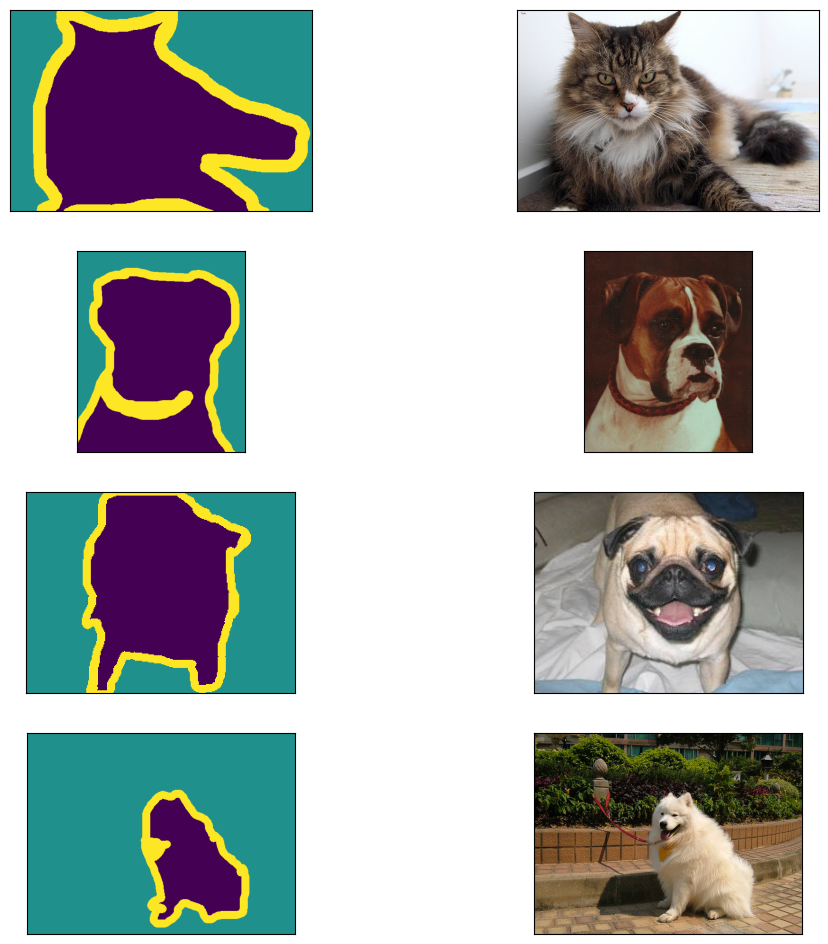

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
# number of classes in the mask
# a class for background, a class for the object (forground), and a class for the object boundary (or also known as niether region)
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [8]:
# create a sagemaker role
role = sagemaker.get_execution_role()

# A bucket is a fundamental storage container within AWS Simple Storage Service (S3).
# A bucket provides a secure and scalable way to store and retrieve any amount of data from anywhere on the web.
# You need to create the S3 bucket (from the AWS website) before you can use it.
# note that the bucket name must be unique across all AWS accounts (not just your account)!
bucket_name = "petdatamy"

# we'll be using the sagemaker's built-in semantic segmentation algorithm
# the algorithm is a pre-built container that is hosted on Amazon Elastic Container Registry (ECR)
# the `training_image`, refers to the URI of the container image that contains the algorithm
# `boto3.Session().region_name` is the region where the algorithm is hosted
training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation', repo_version='latest')

print(f"Training image: {training_image}")

[03/29/25 01:33:11] INFO     Found credentials from IAM Role:                                   ]8;id=801520;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=692591;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=447920;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=349302;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=580569;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=435337;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=324915;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=593586;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Training image: 825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [9]:
# train -> holds training images
# validation -> holds validation images

# train_annotation -> holds training trimaps (masks)
# validation_annotation -> holds validation trimaps (masks)

# todo: put these folders in a separate directory. Remember to change the paths when uploading to S3.
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker
We move the dataset to AWS Bucket for the SageMaker to work on.

In [ ]:
def get_map_file(image):
    """get the trimap for a given image"""
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    # randomly assign 75% of the images to the training set and 25% to the validation set
    # since we are looping over each image once, there is no need to prevent duplicates.
    # note that this random assignment doesn't guarantee exactly 75% / 25% split! It's probabilistic, so we might get slightly different proportions each time the code runs.
    
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    # constructing the image path
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)  # for the bucket
    
    # constructing the trimap path
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))  # for the bucket
    
    # copying the images to the target directories
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

 36%|███████████████████████████████                                                        | 2641/7390 [00:11<00:20, 227.03it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17 │   map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))  # f    │
│   18 │                                                                                           │
│   19 │   # copying the images to the target directories                                          │
│ ❱ 20 │   shutil.copy(image_file_path, image_target_path)                                         │
│   21 │   shutil.copy(map_file_path, map_target_path)                                             │
│   22                                                                                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/shutil.py:417 in copy                  │
│                                                                                                  │
│    414 │   """                                                                                   │
│    415 │   if os.path.isdir(dst):                                                                │
│    416 │   │   dst = os.path.join(dst, os.path.basename(src))                                    │
│ ❱  417 │   copyfile(src, dst, follow_symlinks=follow_symlinks)                                   │
│    418 │   copymode(src, dst, follow_symlinks=follow_symlinks)                                   │
│    419 │   return dst                                                                            │
│    420                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/shutil.py:267 in copyfile              │
│                                                                                                  │
│    264 │   │   │   │   │   # Linux                                                               │
│    265 │   │   │   │   │   elif _USE_CP_SENDFILE:                                                │
│    266 │   │   │   │   │   │   try:                                                              │
│ ❱  267 │   │   │   │   │   │   │   _fastcopy_sendfile(fsrc, fdst)                                │
│    268 │   │   │   │   │   │   │   return dst                                                    │
│    269 │   │   │   │   │   │   except _GiveupOnFastCopy:                                         │
│    270 │   │   │   │   │   │   │   pass                                                          │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/shutil.py:142 in _fastcopy_sendfile    │
│                                                                                                  │
│    139 │   offset = 0                                                                            │
│    140 │   while True:                                                                           │
│    141 │   │   try:                                                                              │
│ ❱  142 │   │   │   sent = os.sendfile(outfd, infd, offset, blocksize)                            │
│    143 │   │   except OSError as err:                                                            │
│    144 │   │   │   # ...in oder to have a more informative exception.                            │
│    145 │   │   │   err.filename = fsrc.name                                                      │
╰────────────────────────────────────────────────────────────

In [ ]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

print(f"{len(train_annots)=}, \n{len(train_images)=}")

# Uploading Data to S3

Technically, S3 doesn't have any folder structure.
It uses a flat namespace to store the objects.
However, the S3 console displays the objects in a folder-like structure by using prefixes.
when we specify a prefix, S3 will create a virtual folder structure for us.

In [ ]:
sess = sagemaker.Session()

print("Starting uploading to S3 ...")
print("Uploading train images ...")

s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')

print("Uploading train annotation ...")
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name, key_prefix='train_annotation')

print("Uploading validation images ...")
s3_val_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')

print("Uploading validation annotation ...")
s3_val_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, key_prefix='validation_annotation')

print(f"Finished uploading to S3")

# SageMaker Estimator

# Hyperparameters

# Data Channels

# Model Training

# Deploy Model

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [ ]:
mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path));

In [ ]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)